In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [23]:
DATASET_PATH = "./datasets/birds/birds.csv"

birds = open(DATASET_PATH, "r").read().splitlines()

print("First 10 birds in the dataset:\n")
print(", ".join(birds[:10]))
print(f"There are {len(birds):,d} birds in the dataset.")

min_length = map(len, birds)
max_length = map(len, birds)
print(f"\nThe shortest character name has {min(min_length)} characters.")
print(f"The longest character name has {max(max_length)} characters.")

First 10 birds in the dataset:

Abbott's babbler, Abbott's booby, Abbott's starling, Abbott's sunbird, Abd al-Kuri sparrow, Abdim's stork, Aberdare cisticola, Aberrant bush warbler, Abert's towhee, Abyssinian catbird
There are 10,976 birds in the dataset.

The shortest character name has 3 characters.
The longest character name has 35 characters.


In [24]:
from unidecode import unidecode

def clean_name(name):
    """
    Clean the bird name by:
    - Removing leading and trailing whitespaces
    - Converting to lowercase
    - Removing accents
    - Removing special characters
    - Replacing spaces with underscores
    """

    name = name.strip().lower()
    # replace special characters with a space
    name = ''.join(char if char.isalnum() or char.isspace() else ' ' for char in name)
    name = name.replace("`", "_")  # Remove apostrophes
    name = name.replace(" ", "_")
    name = unidecode(name)
    return name

In [25]:
# clean all names in the dataset
birds = list(map(clean_name, birds))

# create a mapping from tokens to indices
unique_tokens = set([c for w in birds for c in w])
SPECIAL_TOKEN = "."
index_to_token = {i: t for i, t in enumerate(unique_tokens, start=1)}
token_to_index = {v: k for k, v in index_to_token.items()}
index_to_token[0] = SPECIAL_TOKEN
token_to_index[SPECIAL_TOKEN] = 0
vocab_size = len(unique_tokens) + 1

# log information about the tokenization
print(f"Number of unique tokens: {len(unique_tokens)}")
print(", ".join(sorted(unique_tokens)))
print(f"\nToken mapping: {index_to_token}")

Number of unique tokens: 28
_, `, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z

Token mapping: {1: 'd', 2: 'p', 3: 'g', 4: 'r', 5: 'z', 6: 'w', 7: 'n', 8: 'u', 9: 'o', 10: 'h', 11: 'i', 12: 'c', 13: 'k', 14: 'b', 15: 't', 16: 's', 17: 'x', 18: 'y', 19: 'j', 20: 'a', 21: 'v', 22: '_', 23: 'l', 24: 'q', 25: '`', 26: 'm', 27: 'f', 28: 'e', 0: '.'}


In [26]:
# Model parameters
CONTEXT_SIZE = 3
N_EMBEDDINGS = 10
N_HIDDEN = 64
N_TOKEN = len(token_to_index)

# Training parameters
TRAINING_SET_PORTION = 0.8
DEVELOPMENT_SET_PORTION = 0.1
TEST_SET_PORTION = 1 - (TRAINING_SET_PORTION + DEVELOPMENT_SET_PORTION)

In [27]:
def build_datasets(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Build datasets from a list of words by creating input and target tensors.
    
    Args:
        words (list[str]): List of words to build the datasets from.
        
    Returns:
        tuple[torch.Tensor, torch.Tensor]: Tuple containing the input tensor X and target tensor Y.
    """
    # Create a mapping from tokens to indices
    X, Y = [], []
    
    # Create the context for each character in the words
    for w in words:
        context = [0] * CONTEXT_SIZE
        for ch in w + SPECIAL_TOKEN:  # Add special token at the end
            ix = token_to_index[ch]
            X.append(context)
            Y.append(ix)
            # Update the context by shifting it and adding the new index 
            context = context[1:] + [ix]

    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.int64)
    Y = torch.tensor(Y, dtype=torch.int64)

    return X, Y
    
# Shuffle the words
random.seed(1234)
random.shuffle(birds)

# Split the dataset into training, development, and test sets
train_size = int(TRAINING_SET_PORTION * len(birds))
dev_size = int(DEVELOPMENT_SET_PORTION * len(birds))

X_train, Y_train = build_datasets(birds[:train_size])
X_dev, Y_dev = build_datasets(birds[train_size:train_size + dev_size])
X_test, Y_test = build_datasets(birds[train_size + dev_size:])

# print tensor shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Development set shape:", X_dev.shape, Y_dev.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: torch.Size([172513, 3]) torch.Size([172513])
Development set shape: torch.Size([21531, 3]) torch.Size([21531])
Test set shape: torch.Size([21461, 3]) torch.Size([21461])


In [28]:
def cmp(s, dt, t):
    """
    Compare the true gradient dt and the approximate gradient t.grad.
    Print the results in a table format.
    """
    assert t.grad.shape == dt.shape, f"Shape mismatch: expected {t.grad.shape}, got {dt.shape}"

    exact = torch.all(dt==t.grad).item()
    approx = torch.allclose(dt, t.grad)
    max_diff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(exact):5s} | approximate: {str(approx):5s} | maxdiff: {max_diff}')

In [29]:
g = torch.Generator().manual_seed(123456789) # for reproducibility

# Embedding matrix
C = torch.randn((N_TOKEN, N_EMBEDDINGS), generator=g)

# Layer 1
W1 = torch.randn((N_EMBEDDINGS * CONTEXT_SIZE, N_HIDDEN), generator=g) * (5/3) / (N_EMBEDDINGS * CONTEXT_SIZE)**0.5
b1 = torch.randn(N_HIDDEN, generator=g) * 0.1

# Layer 2
W2 = torch.randn((N_HIDDEN, N_TOKEN), generator=g) * 0.1
b2 = torch.randn(N_TOKEN, generator=g) * 0.1

# Batch normalization
bngain = torch.randn((1, N_HIDDEN), generator=g) * 0.1 + 1.0
bnbias = torch.randn((1, N_HIDDEN), generator=g) * 0.1

# Parameters
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# Model size
print(f"Model size: {sum(p.numel() for p in parameters):,}")

# Turn on gradient tracking
for p in parameters:
    p.requires_grad = True

Model size: 4,287


In [30]:
batch_size = 32
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [31]:
# Forward pass on a single batch
n = batch_size
emb = C[Xb]                                            # shape (batch_size, context_size, embedding_size)
embcat = emb.view(emb.shape[0], -1)                    # shape (batch_size, context_size * embedding_size)

# Layer 1
hprebn = embcat @ W1 + b1                              # shape (batch_size, hidden_size)

# Batch normalization
bnmeani = hprebn.sum(dim=0, keepdim=True) / n          # shape (1, hidden_size)
bndiff = hprebn - bnmeani                              # shape (batch_size, hidden_size)
bndiff2 = bndiff ** 2                                  # shape (batch_size, hidden_size)
bnvar = bndiff2.sum(dim=0, keepdim=True) / (n - 1)     # shape (1, hidden_size)
bnvar_inv = 1 / torch.sqrt(bnvar + 1e-5)               # shape (1, hidden_size)
bnraw = bndiff * bnvar_inv                             # shape (batch_size, hidden_size)
hpreact = bngain * bnraw + bnbias                      # shape (batch_size, hidden_size)

# Non-linearity
h = torch.tanh(hpreact)                                # shape (batch_size, hidden_size)
logits = h @ W2 + b2                                   # shape (batch_size, vocab_size)

# Cross-entropy loss
logit_maxes = logits.max(dim=1, keepdim=True).values   # shape (batch_size, 1)
norm_logits = logits - logit_maxes                     # shape (batch_size, vocab_size)
counts = norm_logits.exp()                             # shape (batch_size, vocab_size)
counts_sum = counts.sum(dim=1, keepdim=True)           # shape (batch_size, 1)
counts_sum_inv = counts_sum ** -1                      # shape (batch_size, 1)
probs = counts * counts_sum_inv                        # shape (batch_size, vocab_size)
logprobs = probs.log()                                 # shape (batch_size, vocab_size)
loss = - logprobs[range(logprobs.shape[0]), Yb].mean() # shape (1)  

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs, probs, counts_sum_inv, counts_sum, counts,
    norm_logits, logit_maxes, logits, h, hpreact,
    bnraw, bnvar_inv, bnvar, bndiff, bndiff2,
    bnmeani, hprebn, embcat, emb
    ]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4834, grad_fn=<NegBackward0>)

In [32]:
# Compute all the gradients manually and compare with PyTorch backward pass
dlogprobs = torch.zeros_like(logprobs).index_put((torch.Tensor(range(n)).int(), Yb), torch.tensor(-1/n))        # shape (batch_size, vocab_size)
dprobs = dlogprobs * (1 / probs)                                                                                # shape (batch_size, vocab_size)
dcounts_sum_inv = (dprobs * counts).sum(dim=1, keepdim=True)                                                    # shape (batch_size, 1)
dcounts_sum = dcounts_sum_inv * ( - 1 / counts_sum ** 2 )                                                       # shape (batch_size, 1)
dcounts = counts_sum_inv * dprobs + torch.ones_like(counts) * dcounts_sum                                       # shape (batch_size, vocab_size)
dnorm_logits = dcounts * counts                                                                                 # shape (batch_size, vocab_size)
dlogit_maxes = (-dnorm_logits).sum(dim=1, keepdim=True)                                                         # shape (batch_size, 1)
dlogits = dlogit_maxes * F.one_hot(logits.max (1).indices, num_classes=logits.shape [1]) + dnorm_logits.clone() # shape (batch_size, vocab_size)
dh = dlogits @ W2.T                                                                                             # shape (batch_size, hidden_size)
dW2 = h.T @ dlogits                                                                                             # shape (hidden_size, hidden_size)
db2 = dlogits.sum(dim=0, keepdim=False)                                                                         # shape (hidden_size)
dhpreact = dh * (1 - h ** 2)                                                                                    # shape (batch_size, hidden_size)
dbngain = (dhpreact * bnraw).sum(dim=0, keepdim=True)                                                           # shape (1, hidden_size)
dbnbias = dhpreact.sum(dim=0, keepdim=True)                                                                     # shape (1, hidden_size)
dbnraw = (dhpreact * bngain)                                                                                    # shape (batch_size, hidden_size)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)                                                             # shape (1, hidden_size)
dbnvar = (-0.5*(bnvar + 1.0e-5)**-1.5) * dbnvar_inv                                                             # shape (1, hidden_size)
# Using tbe bnvar grad instead of the manually computed value to prevent the numerical rounding to compound
dbndiff2 = bnvar.grad * torch.ones_like(bndiff2) / (n-1)                                                        # shape (batch_size, hidden_size)
dbndiff = dbndiff2 * 2 * bndiff + dbnraw * bnvar_inv                                                            # shape (batch_size, hidden_size)
dbnmeani = - dbndiff.sum(0, keepdim=True)                                                                       # shape (batch_size, 1)
dhprebn = dbndiff + dbnmeani * (1/n)                                                                            # shape (batch_size, hidden_size)
dembcat = dhprebn @ W1.T                                                                                        # shape (batch_size, vocab_size)
dW1 = embcat.T @ dhprebn                                                                                        # shape (hidden_size, vocab_size)
db1 = dhprebn.sum(dim=0, keepdim=False)                                                                         # shape (hidden_size)
demb = dembcat.view(emb.shape)                                                                                  # shape (vocab_size)
dC = torch.zeros_like(C)                                                                                        # shape (vocab_size, N_EMBEDDINGS)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]


In [33]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [34]:
# backprop through cross_entropy but all in one go

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:

loss_fast = F.cross_entropy(logits, Yb)
print(f"Loss fast: {loss_fast.item()}, diff: {(loss_fast - loss) / loss:.5%}")

Loss fast: 3.48343825340271, diff: 0.00000%


In [35]:
# backward pass

# -----------------
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n
# -----------------

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


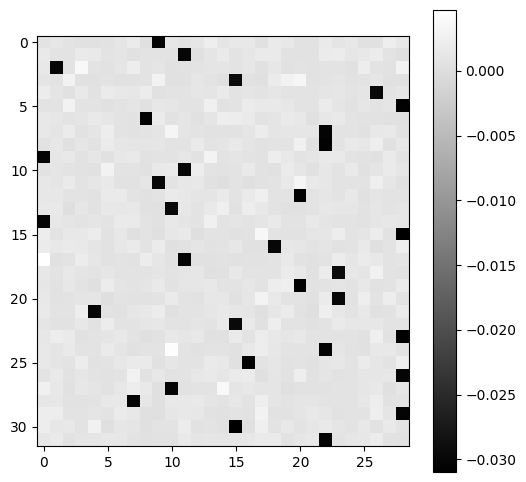

In [36]:
plt.figure(figsize=(6, 6))
plt.imshow(dlogits.detach(), cmap='gray')
plt.colorbar()
plt.show();

In [37]:
# backprop through batchnorm but all in one go
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(3.5763e-07, grad_fn=<MaxBackward1>)


In [38]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)

# -----------------
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw* (dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [49]:
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * CONTEXT_SIZE, n_hidden), generator=g) * (5/3)/((n_embd * CONTEXT_SIZE)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12719
      0/ 200000: 3.8111


  10000/ 200000: 1.5936
  20000/ 200000: 2.1010
  30000/ 200000: 1.4711
  40000/ 200000: 2.1248
  50000/ 200000: 1.6181
  60000/ 200000: 1.7196
  70000/ 200000: 1.2026
  80000/ 200000: 1.3953
  90000/ 200000: 1.4356
 100000/ 200000: 1.4518
 110000/ 200000: 1.2661
 120000/ 200000: 1.2207
 130000/ 200000: 1.4259
 140000/ 200000: 1.5294
 150000/ 200000: 1.5008
 160000/ 200000: 1.4570
 170000/ 200000: 1.6469
 180000/ 200000: 1.1593
 190000/ 200000: 1.3232


In [50]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [51]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.3426601886749268
val 1.3950341939926147
